In [1]:
using LinearAlgebra
using QuantumOptics
using DynamicPolynomials
using TSSOS
using QuadGK
using JuMP
using Random
using NLopt

In [2]:
# Define Pauli matrices
I₂ = Matrix{ComplexF64}(I, 2, 2)
X = [0 1; 1 0]
Y = [0 -1*im; 1*im 0]
Z = [1 0; 0 -1]

@polyvar x[1:3]
@polyvar t[1:3]

function u(t, x)
    # the polynomial shape for control
    sum(x[n] * t^(n - 1) for n = 1:length(x))
end

function commutator(a, b)
    a * b - b * a
end 

# Create a single-site operator on an N-spin system
function kron_N(op::AbstractMatrix, pos::Int, N::Int)
    ops = [I₂ for _ in 1:N]
    ops[pos] = op
    return foldl(kron, ops)
end

# Two-site operator (e.g., Z_i Z_{i+1})
function kron_N2(op1::AbstractMatrix, i::Int, op2::AbstractMatrix, j::Int, N::Int)
    ops = [I₂ for _ in 1:N]
    ops[i] = op1
    ops[j] = op2
    return foldl(kron, ops)
end

# Ising Hamiltonian
function ising_hamiltonian(N::Int,t,x; J=0.1, h=1.0)
    H = zeros(ComplexF64, 2^N, 2^N)

    # Interaction term: -J Z_i Z_{i+1}
    for i in 1:(N - 1)
        j = i + 1
        H -= J * kron_N2(Z, i, Z, j, N)
    end

    # Transverse field term: -h X_i
    for i in 1:N
        H -= u(t,x) * h * kron_N(X, i, N)
    end

    return H
end

ising_hamiltonian (generic function with 1 method)

In [3]:
function ∫(p::AbstractPolynomial, x::PolyVar, x_lower, x_upper)
    
    # get the index of the variable of integration
    ind_x = indexin([x], variables(p))[1]
        
    if isnothing(ind_x)
        # integration valuable is not found among vars
        return p * (x_upper - x_lower)
    end
    
    # get the indefinite integral
    int_p = sum(
        term * x * 1 // (exponents(term)[ind_x] + 1) for term in terms(p)
        init = 0 * x
    )
            
    # get the definite integral
    subs(int_p, x=>x_upper) - subs(int_p, x=>x_lower)
end

function ∫(M::AbstractMatrix, x::PolyVar, x_lower, x_upper)
   map(z -> ∫(z, x, x_lower, x_upper), M) 
end

function real_poly(p::Polynomial)
    #=
    Real part of the polynomial
    =#
    sum(
        real(c) * m for (c, m) in zip(coefficients(p), monomials(p))# if ~isapproxzero(abs(c))
    )
end

function square_frobenius_norm(M::AbstractArray)
    #=
    Square of the Frobenius norm of a matrix
    =#
    real_poly(sum(z' * z for z in M))
end

square_frobenius_norm (generic function with 1 method)

In [4]:
function Magnus(H0,V, t_evol)

    T = t_evol

    function A(t, x)
        #=
        The generator of motion entering the Magnus expansion
        =#
        (H0 + V * u(t, x)) / im
    end
    
    # get the partial sum of the Magnus expansion
    A₁ = A(t[1], x)
    A₂ = A(t[2], x)
    
    Ω = ∫(A₁, t[1], 0, T);
    
    # 2nd term in the Magnus expansion
    Ω .+= 1//2 * ∫(∫(
        commutator(A₁, A₂), 
        t[2], 0, t[1]), 
        t[1], 0, T
    );
    
    # 3nd term in the Magnus expansion
    
    A₃ = A(t[3], x)
    
    Ω .+= 1//6 * ∫(∫(∫(
        commutator(A₁, commutator(A₂, A₃)) + commutator(commutator(A₁, A₂), A₃),
        t[3], 0, t[2]),
        t[2], 0, t[1]),
        t[1], 0, T
    );
    
    Ω
end

Magnus (generic function with 1 method)

In [5]:
using SpecialFunctions

"""
Chebyshev approximation for exp(Ω)
"""
function exp_chebyshev(Ω::AbstractMatrix, order::Integer)
    
    Tₙ₋₁ = I
    Tₙ  = Ω
    
    # The first two terms of Chebyshev series for exp
    series = besselj(0, 1) * Tₙ₋₁ + 2 * besselj(1, 1) * Tₙ
    
    for n=2:order
        Tₙ₊₁  = 2 * Ω * Tₙ + Tₙ₋₁
        
        series .+= 2 * besselj(n, 1) * Tₙ₊₁
        
        (Tₙ, Tₙ₋₁) = (Tₙ₊₁, Tₙ) 
    end
    
    series
end

exp_chebyshev

In [6]:
function get_unitary(H0,V,x::AbstractArray,t_evol)

    T = t_evol
    #=
    Get the unitary given the coefficients for the polynomial control
    =#
    basis = NLevelBasis(size(H0)[1])

    𝓗₀ = DenseOperator(basis, basis, H0)
    𝓥 = DenseOperator(basis, basis, V)

    H = LazySum([1., u(0, x)], [𝓗₀, 𝓥])
        
    function 𝓗(t, psi)
        H.factors[2] = u(t, x)
        return H
    end

    _, 𝓤 = timeevolution.schroedinger_dynamic([0, T], identityoperator(basis, basis), 𝓗)
    
    return Matrix(𝓤[2].data)
end

get_unitary (generic function with 1 method)

In [7]:
function get_obj(N,t_evol)

    J = 0.1
    h = 1.0

    H0 = zeros(ComplexF64, 2^N, 2^N)

    # Interaction term: -J Z_i Z_{i+1}
    for i in 1:(N - 1)
        j = i + 1
        H0 -= J * kron_N2(Z, i, Z, j, N)
    end

    V = zeros(ComplexF64, 2^N, 2^N)

    # Transverse field term: -h X_i
    for i in 1:N
        V -= h * kron_N(X, i, N)
    end

    Mag = Magnus(H0,V,t_evol)

    Mag = convert(Matrix{Polynomial{true, ComplexF64}}, Mag)

    Cheby = exp_chebyshev(Mag,4)
    
    Random.seed!(2801)
    exact_x = -1 .+ 2 * rand(length(x))
    U_target = get_unitary(H0,V,exact_x,t_evol)

    obj = square_frobenius_norm(Cheby - U_target)

end

get_obj (generic function with 1 method)

In [8]:
function solve_pop(obj)

    # Get the global minimum via TSSOS library
    opt,sol,data = tssos_first(obj, variables(obj),order=8; QUIET = true, solution = true);
    
    previous_sol = sol
    previous_opt = opt
        
        while ~isnothing(sol)
            previous_sol = sol
            previous_opt = opt
                
            opt,sol,data = tssos_higher!(data; QUIET = true, solution = true);
        end

end

solve_pop (generic function with 1 method)

In [21]:
function get_times(M)

    times_obj = []
    times_pop = []

    for i in 1:M

        print(i)

        t_evol = 1.0/i

        start = time()
        obj = get_obj(i,t_evol)
        elapsed_obj = time() - start

        start = time()
        solve_pop(obj)
        elapsed_pop = time() - start

        push!(times_obj, elapsed_obj)
        push!(times_pop, elapsed_pop)
        
    end

    times_obj, times_pop

end

get_times (generic function with 1 method)

In [25]:
M = 8
reps = 5
times_obj = []
times_pop = []

for i in 1:reps

    print(i)

    time_obj, time_pop = get_times(M)

    push!(times_obj, time_obj)
    push!(times_pop, time_pop)
    
end

11*********************************** TSSOS ***********************************
TSSOS is launching...
optimum = 1.730206112921988e-7
Global optimality certified with relative optimality gap 0.000001%!
No higher TS step of the TSSOS hierarchy!
2*********************************** TSSOS ***********************************
TSSOS is launching...
optimum = 1.5769091543490514e-7
Global optimality certified with relative optimality gap 0.000000%!
No higher TS step of the TSSOS hierarchy!
3*********************************** TSSOS ***********************************
TSSOS is launching...
optimum = 1.5331120697855219e-6
Global optimality certified with relative optimality gap 0.000001%!
No higher TS step of the TSSOS hierarchy!
4*********************************** TSSOS ***********************************
TSSOS is launching...
optimum = 1.8172968686880116e-6
Global optimality certified with relative optimality gap 0.000002%!
No higher TS step of the TSSOS hierarchy!
5***************************

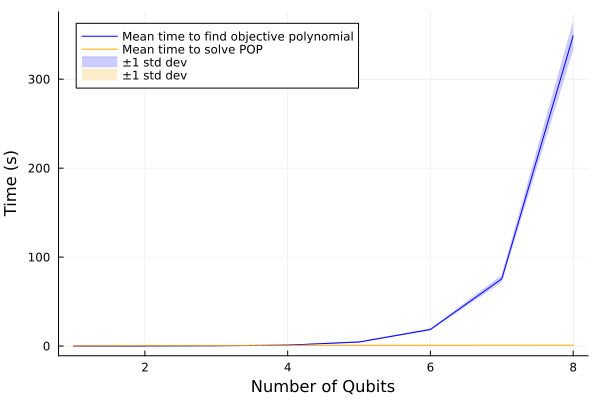

"C:\\Users\\llore\\Documents\\2025\\Code\\QC_POP\\TimeComputation\\Chebyshev_times_compute.png"

In [26]:
using Statistics
using Plots

mat_obj = reduce(hcat, times_obj)
mat_pop = reduce(hcat, times_pop)

means_obj = vec(mean(mat_obj, dims=2))
stds_obj = vec(std(mat_obj, dims=2))

means_pop = vec(mean(mat_pop, dims=2))
stds_pop = vec(std(mat_pop, dims=2))

# Define x-axis values (e.g., indices)
xs = 1:length(means_obj)

# Compute upper and lower bounds
upper_obj = means_obj .+ stds_obj
lower_obj = means_obj .- stds_obj

upper_pop = means_pop .+ stds_pop
lower_pop = means_pop .- stds_pop

# Plot mean line
p = plot(xs, means_obj,
    label="Mean time to find objective polynomial",
    lw=1,
    color=:blue,
    xlabel="Number of Qubits",
    ylabel="Time (s)"
)

plot!(xs, means_pop,
    label="Mean time to solve POP",
    lw=1,
    color=:orange
)

# Fill between upper and lower bounds
plot!(xs, upper_obj,
    fillrange=lower_obj,
    fillalpha=0.2,
    label="±1 std dev",
    lw=0,
    color=:blue
)

plot!(xs, upper_pop,
    fillrange=lower_pop,
    fillalpha=0.2,
    label="±1 std dev",
    lw=0,
    color=:orange
)

display(p)
savefig(p, "Chebyshev_times_compute.png")

## Now with only Magnus

In [27]:
function get_obj_magnus(N,t_evol)

    J = 0.1
    h = 1.0

    H0 = zeros(ComplexF64, 2^N, 2^N)

    # Interaction term: -J Z_i Z_{i+1}
    for i in 1:(N - 1)
        j = i + 1
        H0 -= J * kron_N2(Z, i, Z, j, N)
    end

    V = zeros(ComplexF64, 2^N, 2^N)

    # Transverse field term: -h X_i
    for i in 1:N
        V -= h * kron_N(X, i, N)
    end

    Mag = Magnus(H0,V,t_evol)

    Mag = convert(Matrix{Polynomial{true, ComplexF64}}, Mag)
    
    Random.seed!(2801)
    exact_x = -1 .+ 2 * rand(length(x))
    U_target = get_unitary(H0,V,exact_x,t_evol)
    J = log(U_target)

    obj = square_frobenius_norm(Mag - J)

end

get_obj_magnus (generic function with 1 method)

In [28]:
function get_times_magnus(M)

    times_obj = []
    times_pop = []

    for i in 1:M

        print(i)

        t_evol = 1.0/i

        start = time()
        obj = get_obj_magnus(i,t_evol)
        elapsed_obj = time() - start

        start = time()
        solve_pop(obj)
        elapsed_pop = time() - start

        push!(times_obj, elapsed_obj)
        push!(times_pop, elapsed_pop)
        
    end

    times_obj, times_pop

end

get_times_magnus (generic function with 1 method)

In [29]:
times_obj_m = []
times_pop_m = []

for i in 1:reps

    print(i)

    time_obj_m, time_pop_m = get_times_magnus(M)

    push!(times_obj_m, time_obj_m)
    push!(times_pop_m, time_pop_m)
    
end

11*********************************** TSSOS ***********************************
TSSOS is launching...
optimum = 3.0196706323000015e-8
Global optimality certified with relative optimality gap 0.000426%!
No higher TS step of the TSSOS hierarchy!
2*********************************** TSSOS ***********************************
TSSOS is launching...
optimum = 2.893573140105897e-9
Global optimality certified with relative optimality gap 0.000000%!
No higher TS step of the TSSOS hierarchy!
3*********************************** TSSOS ***********************************
TSSOS is launching...
optimum = -1.3728155924083776e-8
Global optimality certified with relative optimality gap 0.000002%!
No higher TS step of the TSSOS hierarchy!
4*********************************** TSSOS ***********************************
TSSOS is launching...
optimum = -1.8026724154542936e-8
Global optimality certified with relative optimality gap 0.000002%!
No higher TS step of the TSSOS hierarchy!
5*************************

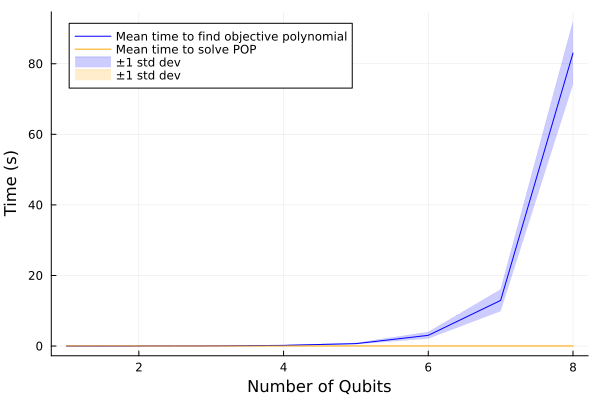

"C:\\Users\\llore\\Documents\\2025\\Code\\QC_POP\\TimeComputation\\Magnus_times_compute.png"

In [30]:
mat_obj_m = reduce(hcat, times_obj_m)
mat_pop_m = reduce(hcat, times_pop_m)

means_obj_m = vec(mean(mat_obj_m, dims=2))
stds_obj_m = vec(std(mat_obj_m, dims=2))

means_pop_m = vec(mean(mat_pop_m, dims=2))
stds_pop_m = vec(std(mat_pop_m, dims=2))

# Define x-axis values (e.g., indices)
xs_m = 1:length(means_obj_m)

# Compute upper and lower bounds
upper_obj_m = means_obj_m .+ stds_obj_m
lower_obj_m = means_obj_m .- stds_obj_m

upper_pop_m = means_pop_m .+ stds_pop_m
lower_pop_m = means_pop_m .- stds_pop_m

# Plot mean line
p_m = plot(xs_m, means_obj_m,
    label="Mean time to find objective polynomial",
    lw=1,
    color=:blue
)

plot!(xs_m, means_pop_m,
    label="Mean time to solve POP",
    lw=1,
    color=:orange,
    xlabel="Number of Qubits",
    ylabel="Time (s)"
)

# Fill between upper and lower bounds
plot!(xs_m, upper_obj_m,
    fillrange=lower_obj_m,
    fillalpha=0.2,
    label="±1 std dev",
    lw=0,
    color=:blue
)

plot!(xs_m, upper_pop_m,
    fillrange=lower_pop_m,
    fillalpha=0.2,
    label="±1 std dev",
    lw=0,
    color=:orange
)

display(p_m)
savefig(p_m, "Magnus_times_compute.png")

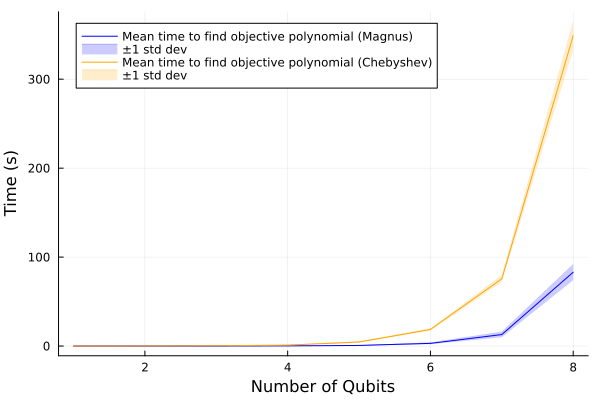

"C:\\Users\\llore\\Documents\\2025\\Code\\QC_POP\\TimeComputation\\Magnus_Chebyshev_obj.png"

In [31]:
# Plot mean line
p_obj = plot(xs_m, means_obj_m,
    label="Mean time to find objective polynomial (Magnus)",
    lw=1,
    color=:blue,
    xlabel="Number of Qubits",
    ylabel="Time (s)"
)

# Fill between upper and lower bounds
plot!(xs_m, upper_obj_m,
    fillrange=lower_obj_m,
    fillalpha=0.2,
    label="±1 std dev",
    lw=0,
    color=:blue
)

# Plot mean line
plot!(xs_m, means_obj,
    label="Mean time to find objective polynomial (Chebyshev)",
    lw=1,
    color=:orange
)

# Fill between upper and lower bounds
plot!(xs_m, upper_obj,
    fillrange=lower_obj,
    fillalpha=0.2,
    label="±1 std dev",
    lw=0,
    color=:orange
)

display(p_obj)
savefig(p_obj, "Magnus_Chebyshev_obj.png")

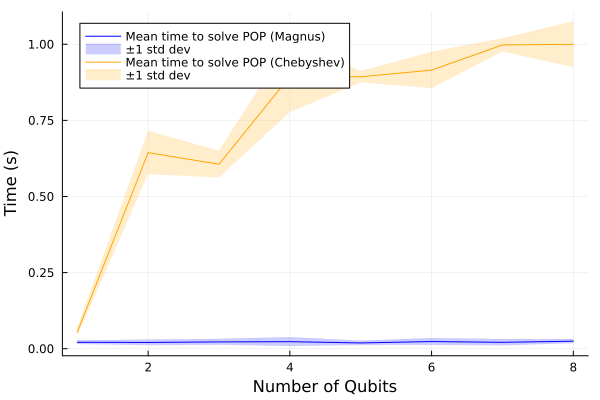

"C:\\Users\\llore\\Documents\\2025\\Code\\QC_POP\\TimeComputation\\Magnus_Chebyshev_pop.png"

In [32]:
# Plot mean line
p_pop = plot(xs_m, means_pop_m,
    label="Mean time to solve POP (Magnus)",
    lw=1,
    color=:blue
)

# Fill between upper and lower bounds
plot!(xs_m, upper_pop_m,
    fillrange=lower_pop_m,
    fillalpha=0.2,
    label="±1 std dev",
    lw=0,
    color=:blue,
    xlabel="Number of Qubits",
    ylabel="Time (s)"
)

# Plot mean line
plot!(xs_m, means_pop,
    label="Mean time to solve POP (Chebyshev)",
    lw=1,
    color=:orange
)

# Fill between upper and lower bounds
plot!(xs_m, upper_pop,
    fillrange=lower_pop,
    fillalpha=0.2,
    label="±1 std dev",
    lw=0,
    color=:orange
)

display(p_pop)
savefig(p_pop, "Magnus_Chebyshev_pop.png")

## Full plot

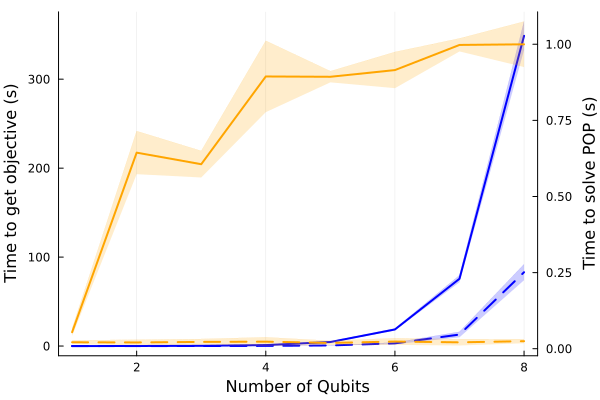

"C:\\Users\\llore\\Documents\\2025\\Code\\QC_POP\\TimeComputation\\merged_Magnus_Chebyshev_obj_pop_updated_with_legend.png"

In [33]:
using Plots

# Start the first plot (left y-axis) for Magnus (blue, dashed)
p = plot(xs_m, means_obj_m,
    lw=2,
    color=:blue,
    linestyle=:dash,
    xlabel="Number of Qubits",
    ylabel="Time to get objective (s)",
    legend=false
)

# Fill between upper and lower bounds for objective (Magnus)
plot!(xs_m, upper_obj_m,
    fillrange=lower_obj_m,
    fillalpha=0.2,
    lw=0,
    color=:blue
)

# Add Chebyshev objective curve with orange color and solid line style
plot!(xs_m, means_obj,
    lw=2,
    color=:blue,
    linestyle=:solid
)

# Fill between upper and lower bounds for objective (Chebyshev)
plot!(xs_m, upper_obj,
    fillrange=lower_obj,
    fillalpha=0.2,
    lw=0,
    color=:blue
)

# Create a second y-axis (right) and plot POP-related data for Magnus (blue, dashed)
p2 = twinx()

# Plot Magnus POP data with orange color and dashed line style
plot!(p2, xs_m, means_pop_m,
    lw=2,
    color=:orange,
    linestyle=:dash,
    ylabel="Time to solve POP (s)",
    legend=false
)

# Fill between upper and lower bounds for POP (Magnus)
plot!(p2, xs_m, upper_pop_m,
    fillrange=lower_pop_m,
    fillalpha=0.2,
    lw=0,
    color=:orange
)

# Plot Chebyshev POP data with orange color and solid line style
plot!(p2, xs_m, means_pop,
    lw=2,
    color=:orange,
    linestyle=:solid
)

# Fill between upper and lower bounds for POP (Chebyshev)
plot!(p2, xs_m, upper_pop,
    fillrange=lower_pop,
    fillalpha=0.2,
    lw=0,
    color=:orange
)

# Blue (Magnus, Dashed)
scatter!(p, [NaN], [NaN], label="Magnus - Dashed (Blue)", color=:blue, linestyle=:dash)

# Blue (Chebyshev, Solid)
scatter!(p, [NaN], [NaN], label="Chebyshev - Solid (Blue)", color=:blue, linestyle=:solid)

# Orange (Magnus, Dashed)
scatter!(p2, [NaN], [NaN], label="Magnus - Dashed (Orange)", color=:orange, linestyle=:dash)

# Orange (Chebyshev, Solid)
scatter!(p2, [NaN], [NaN], label="Chebyshev - Solid (Orange)", color=:orange, linestyle=:solid)

# Display and save the final merged plot
display(p)
savefig(p, "merged_Magnus_Chebyshev_obj_pop_updated_with_legend.png")


## Save the data

In [34]:
using HDF5


h5open("results.hdf5", "w") do fid
    fid["means_obj"] = means_obj
    fid["means_pop"] = means_pop
    fid["stds_obj"] = stds_obj
    fid["stds_pop"] = stds_pop
    fid["means_obj_m"] = means_obj_m
    fid["means_pop_m"] = means_pop_m
    fid["stds_obj_m"] = stds_obj_m
    fid["stds_pop_m"] = stds_pop_m
end;